In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import kerastuner as kt
import pickle
import joblib
from scipy import stats
from numpy import load
from numpy import save
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [2]:
sns.set_style("white")

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

### Read data for str1 and str2

In [5]:
str1_df = pd.read_csv("../data/str1_df.csv", delimiter=",")
str1_df = str1_df.rename(columns={'Str1TempMittelLsInC_mean': 'TempMittelLsInC_mean', 'Str1TempMittelFsInC_mean': 'TempMittelFsInC_mean'})

In [6]:
str2_df = pd.read_csv("../data/str2_df.csv", delimiter=",")
str2_df = str2_df.rename(columns={'Str2TempMittelLsInC_mean': 'TempMittelLsInC_mean', 'Str2TempMittelFsInC_mean': 'TempMittelFsInC_mean'})

### Combine Dataframes

In [7]:
df_cc4 = pd.concat([str1_df,str2_df],axis=0)
df_cc4 = df_cc4.reset_index(drop=True)
df_cc4 = df_cc4.drop(['ChargenNrErsteSchmInSeq'],axis=1)

### Drop some attributes

In [8]:
data = df_cc4.drop([
       'z1_begin_time', 'z1_delta_time', 'z1_end_time', 
       'z2a_begin_time', 'z2a_delta_time',  'z2a_end_time',
        'z2b_begin_time', 'z2b_delta_time', 
       'z2b_end_time',  'z3a_begin_time', 'z3a_delta_time',
        'z3a_end_time',  'z3b_begin_time',
       'z3b_delta_time',  'z3b_end_time', 
       'z4_begin_time', 'z4_delta_time',  'z4_end_time', 
       'z5_begin_time', 'z5_delta_time',  'z5_end_time', 
       'zpy_begin_time', 'zpy_delta_time',  'zpy_end_time','GiessBeginnSchmelze', 'GiessBeginn_DateTime',
       'GiessEndeSchmelze', 'GiessEnde_DateTime', 'EndeSchmelze',
       'Ende_DateTime', 'NrSchmelzeInSequenz', ],axis=1)

### One hot encoding for format attribute

In [9]:
formats = np.array(data['Format'])
format_endocer = OneHotEncoder()
format_1hot = format_endocer.fit_transform(formats.reshape(-1, 1))
df_format = pd.DataFrame(format_1hot.toarray(), columns=format_endocer.get_feature_names())
df_format.rename(columns={'x0_1825':'Format_1825', 'x0_2230':'Format_2230', 'x0_2234':'Format_2234', 'x0_2235':'Format_2235' }, inplace=True)

data = pd.concat((data, df_format), axis=1)

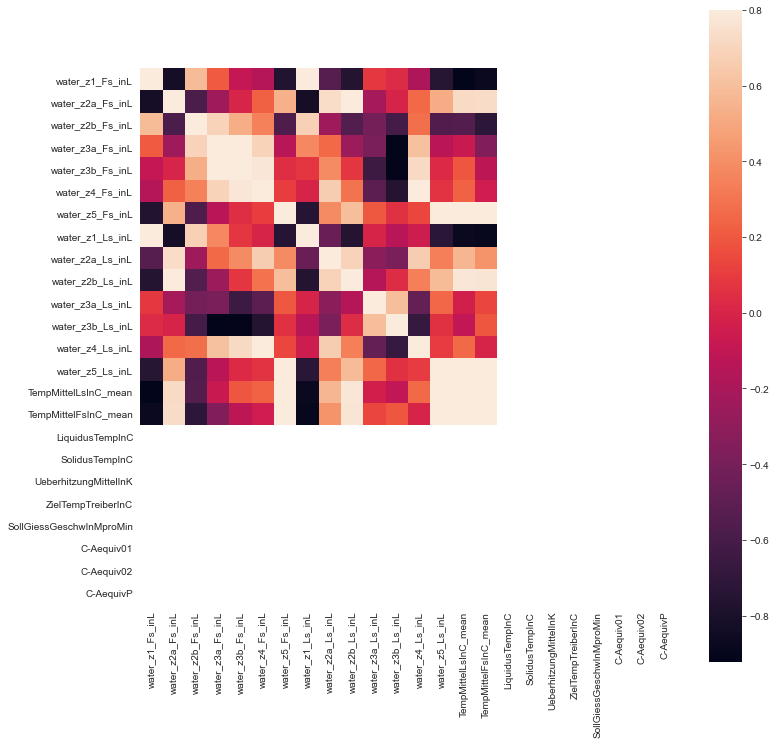

In [10]:
import seaborn as sns
corrmat = data.drop(['ChargenNr','SequenzNr', 'strang_nr', 'ith_section', 'Format', 'Format_2235' ] , axis=1).corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

In [11]:
corrmat['TempMittelLsInC_mean'].sort_values()

water_z1_Fs_inL            -0.919168
water_z1_Ls_inL            -0.881991
water_z2b_Fs_inL           -0.548719
water_z3b_Ls_inL           -0.106102
water_z3a_Fs_inL           -0.069948
water_z3a_Ls_inL           -0.027981
water_z3b_Fs_inL            0.188929
water_z4_Fs_inL             0.234064
water_z4_Ls_inL             0.260758
water_z2a_Ls_inL            0.563536
water_z2a_Fs_inL            0.725130
water_z2b_Ls_inL            0.776247
water_z5_Ls_inL             0.906593
water_z5_Fs_inL             0.918152
TempMittelFsInC_mean        0.941870
TempMittelLsInC_mean        1.000000
LiquidusTempInC                  NaN
SolidusTempInC                   NaN
UeberhitzungMittelInK            NaN
ZielTempTreiberInC               NaN
SollGiessGeschwInMproMin         NaN
C-Aequiv01                       NaN
C-Aequiv02                       NaN
C-AequivP                        NaN
Name: TempMittelLsInC_mean, dtype: float64

## Duplicate data and give different sequence name in order to have different sequences for different sets

In [12]:
data_old = data.copy()

for i in range(1,11):
    data_1 = data_old.copy()
    data_1['SequenzNr'] = data_1['SequenzNr'] + i #new sequence with same values
    data_1['seq_id'] =  str(data_1['SequenzNr']) + '_str_' + str(data_1['strang_nr'])
    data = pd.concat([data, data_1])

# change sequences id 
def seq_and_str_nr(row):
    row['seq_id'] = str(row['SequenzNr']) + '_str_' + str(row['strang_nr'])
    return row

data = data.apply(seq_and_str_nr, axis=1)

#### Data cleaning

In [13]:
data_prep = data[data['ith_section']>0]  # drop the first section of each sequence
data_prep = data_prep.drop(['ChargenNr','ith_section', 'strang_nr'],axis=1)  
data_prep = data_prep.reset_index(drop=True)

columns = data_prep.columns

In [14]:
labels = ['TempMittelLsInC_mean', 'TempMittelFsInC_mean']

unwanted = ['Format', 'UeberhitzungMittelInK', 'SollGiessGeschwInMproMin','SequenzNr', 'seq_id']

features =  [e for e in columns if e not in (labels+unwanted)]

In [15]:
# with open('../data/mlp_transformed/label_keys_mlp.pkl', 'wb') as fp:
#     pickle.dump(labels, fp)
# with open('../data/mlp_transformed/feature_keys_mlp.pkl', 'wb') as fp:
#     pickle.dump(features, fp)

### Same Sequences as for LSTM

In [16]:
sequences = data_prep.groupby('SequenzNr')
seq_keys_mlp = list(sequences.groups.keys())

from sklearn.model_selection import train_test_split
train_full, test_keys = train_test_split(seq_keys_mlp, test_size=0.25, random_state=42)
train_keys, valid_keys = train_test_split(train_full, test_size=0.25, random_state=42)

In [17]:
def create_set(key_set,data):
    df = pd.DataFrame()
    for key in key_set:
        df2 = pd.DataFrame()
        df2 = data[data['SequenzNr']==key]
       
        
        df = pd.concat([df,df2],axis=0)
    return df

In [18]:
train_data = create_set(train_keys, data_prep)
train_data = train_data.reset_index(drop=True)

valid_data = create_set(valid_keys, data_prep)
valid_data = valid_data.reset_index(drop=True)

test_data = create_set(test_keys, data_prep)
test_data = test_data.reset_index(drop=True)

In [19]:
all_train_data = pd.concat([train_data, valid_data], axis=0).reset_index(drop=True)

In [20]:
test_data_evaluation = create_set(test_keys, df_cc4[df_cc4['ith_section']>0])
test_data_evaluation = test_data_evaluation.reset_index()

## Normalizing the data

#### Train and Validation Data

In [21]:
train_X_unsc = train_data[features]
train_y_unsc = train_data[labels]
valid_X_unsc = valid_data[features]
valid_y_unsc = valid_data[labels]

scaler_x_train = MinMaxScaler()
train_X = scaler_x_train.fit_transform(train_X_unsc)
valid_X = scaler_x_train.transform(valid_X_unsc)

scaler_y_train = MinMaxScaler()
train_y = scaler_y_train.fit_transform(train_y_unsc)
valid_y = scaler_y_train.transform(valid_y_unsc)


#### All known Data and Test Data

In [22]:
all_X_unsc = all_train_data[features]
all_y_unsc = all_train_data[labels]
test_X_unsc = test_data[features]
test_y_unsc = test_data[labels]

scaler_x = MinMaxScaler()
all_X = scaler_x.fit_transform(all_X_unsc)
test_X = scaler_x.transform(test_X_unsc)

scaler_y = MinMaxScaler()
all_y = scaler_y.fit_transform(all_y_unsc)
test_y = scaler_y.transform(test_y_unsc)

### Save data

In [23]:
# test_data_evaluation.to_pickle('../data/mlp_transformed/test_data_evaluation.pkl')
# train_data.to_pickle("../data/mlp_transformed/train_unsc_mlp.pkl")
# valid_data.to_pickle("../data/mlp_transformed/valid_unsc_mlp.pkl")
# test_data.to_pickle("../data/mlp_transformed/test_unsc_mlp.pkl")
# all_train_data.to_pickle("../data/mlp_transformed/all_train_unsc_mlp.pkl")

In [24]:
# save('../data/mlp_transformed/train_x_mlp.npy', train_X)
# save('../data/mlp_transformed/train_y_mlp.npy', train_y)
# save('../data/mlp_transformed/valid_x_mlp.npy', valid_X)
# save('../data/mlp_transformed/valid_y_mlp.npy', valid_y)
# save('../data/mlp_transformed/test_x_mlp.npy', test_X)
# save('../data/mlp_transformed/test_y_mlp.npy', test_y)
# save('../data/mlp_transformed/all_x_mlp.npy', all_X)
# save('../data/mlp_transformed/all_y_mlp.npy', all_y)

#### save scaler

In [25]:
# scaler_x_filename = "../data/mlp_transformed/scaler_x_mlp.save"
# joblib.dump(scaler_x, scaler_x_filename)

# scaler_y_filename = "../data/mlp_transformed/scaler_y_mlp.save"
# joblib.dump(scaler_y, scaler_y_filename)

# scaler_y_filename = "../data/mlp_transformed/scaler_y_train_mlp.save"
# joblib.dump(scaler_y_train, scaler_y_filename)